In [3]:
import pandas as pd
import numpy as np

# Load the transaction data
transaction_data = pd.read_csv(r"D:\Sayali\QuantiQuantium -Internship\QVI_data.csv")

# Convert date columns to datetime type if necessary
transaction_data['DATE'] = pd.to_datetime(transaction_data['DATE'])

# Filter data for the pre-trial period
pre_trial_data = transaction_data[transaction_data['DATE'] < '2019-02-01']

# Calculate summary statistics for each store
store_metrics = pre_trial_data.groupby('STORE_NBR').agg({
    'TOT_SALES': 'sum',
    'LYLTY_CARD_NBR': 'nunique',
    'TXN_ID': 'count'
}).reset_index()

# Rename columns for clarity
store_metrics.columns = ['store_number', 'total_sales', 'num_customers', 'num_transactions']

# Calculate transactions per customer
store_metrics['transactions_per_customer'] = store_metrics['num_transactions'] / store_metrics['num_customers']

# Print the summary statistics
print(store_metrics)

     store_number  total_sales  num_customers  num_transactions  \
0               1      1386.90            245               332   
1               2      1128.50            221               287   
2               3      7526.15            334               878   
3               4      9127.00            350              1044   
4               5      5739.70            231               818   
..            ...          ...            ...               ...   
266           268      1549.05            228               320   
267           269      6664.50            247               956   
268           270      6697.95            239               975   
269           271      5765.10            231               817   
270           272      2744.35            217               329   

     transactions_per_customer  
0                     1.355102  
1                     1.298643  
2                     2.628743  
3                     2.982857  
4                     3.541126

1. The code starts by importing the necessary libraries: pandas for data manipulation and numpy for numerical operations.

2. It loads the transaction data from a CSV file located at the specified path.

3. The 'DATE' column is converted to the datetime data type using `pd.to_datetime`.

4. The data is filtered to include only the pre-trial period, which is before '2019-02-01'.

5. The `groupby` function is used to group the data by 'STORE_NBR' (store number), and the `agg` function is applied to calculate summary statistics for each store:
   - 'TOT_SALES': Sum of total sales
   - 'LYLTY_CARD_NBR': Count of unique loyalty card numbers (proxy for the number of customers)
   - 'TXN_ID': Count of transactions

6. The resulting DataFrame (`store_metrics`) is reset with an index, and the columns are renamed for better clarity.

7. A new column 'transactions_per_customer' is added, which is calculated by dividing the 'num_transactions' by 'num_customers' for each store.

8. Finally, the `store_metrics` DataFrame is printed, displaying the summary statistics for each store.

Output Discussion:
The output is a DataFrame with 271 rows (one for each store) and 5 columns:

- 'store_number': The store number
- 'total_sales': The total sales for the pre-trial period
- 'num_customers': The number of unique customers (based on loyalty card numbers)
- 'num_transactions': The total number of transactions
- 'transactions_per_customer': The average number of transactions per customer

This output gives us an overview of the performance of each store during the pre-trial period. It provides metrics like total sales, customer count, transaction count, and the average number of transactions per customer. These metrics can be used to identify suitable control stores for the trial stores by comparing their performance before the trial period.

For example, if we want to select a control store for the trial store with 'store_number' 77, we can look for stores with similar total sales, customer count, and transactions per customer during the pre-trial period.

The summary statistics can also be used to gain insights into the overall performance of the stores and identify potential areas for improvement or further analysis.

In [4]:
# Extract metrics for trial stores
trial_stores = store_metrics[store_metrics['store_number'].isin([77, 86, 88])]
print(trial_stores)

# Define a function to calculate similarity score (e.g., Euclidean distance)
def calculate_similarity(row, trial_store):
    return np.sqrt(
        (row['total_sales'] - trial_store['total_sales'])**2 +
        (row['num_customers'] - trial_store['num_customers'])**2 +
        (row['transactions_per_customer'] - trial_store['transactions_per_customer'])**2
    )

# Calculate similarity for each trial store and find control stores
control_stores = {}
for index, trial_store in trial_stores.iterrows():
    store_metrics['similarity_score'] = store_metrics.apply(lambda row: calculate_similarity(row, trial_store), axis=1)
    control_store = store_metrics[(store_metrics['store_number'] != trial_store['store_number']) & (store_metrics['store_number'].isin([77, 86, 88]) == False)].sort_values('similarity_score').iloc[0]
    control_stores[trial_store['store_number']] = control_store['store_number']

print(control_stores)


    store_number  total_sales  num_customers  num_transactions  \
76            77      1699.00            239               317   
85            86      6119.85            254               882   
87            88      9383.60            374              1082   

    transactions_per_customer  
76                   1.326360  
85                   3.472441  
87                   2.893048  
{77.0: 188.0, 86.0: 13.0, 88.0: 237.0}


Based on the analysis, we have identified control stores for each trial store based on their similarity in terms of total sales, number of customers, and transactions per customer. Here are the conclusions and results:

1. **Store 77:**
   - Total Sales: \$1699.00
   - Number of Customers: 239
   - Transactions per Customer: 1.33
   - Control Store: 188

2. **Store 86:**
   - Total Sales: \$6119.85
   - Number of Customers: 254
   - Transactions per Customer: 3.47
   - Control Store: 13

3. **Store 88:**
   - Total Sales: \$9383.60
   - Number of Customers: 374
   - Transactions per Customer: 2.89
   - Control Store: 237

**Conclusion:**

Based on the similarity analysis and control store selection, we have identified the following control stores for each trial store:
- Store 77: Control Store 188
- Store 86: Control Store 13
- Store 88: Control Store 237

These control stores will be used for comparison during the trial period to assess the effectiveness of the new layout changes. By comparing the sales performance of trial stores against their respective control stores during the trial period, we can determine whether the new layout resulted in a significant uplift in sales.

In [5]:
# Filter data for the trial period
trial_data = transaction_data[(transaction_data['DATE'] >= '2019-02-01') & (transaction_data['DATE'] <= '2019-04-30')]

# Aggregate sales data for trial stores
trial_performance = trial_data[trial_data['STORE_NBR'].isin([77, 86, 88])].groupby('STORE_NBR')['TOT_SALES'].sum().reset_index()
trial_performance.columns = ['STORE_NBR', 'TOT_SALES_trial']

# Aggregate sales data for control stores
control_performance = trial_data[trial_data['STORE_NBR'].isin(control_stores.values())].groupby('STORE_NBR')['TOT_SALES'].sum().reset_index()
control_performance.columns = ['STORE_NBR', 'TOT_SALES_control']

# Print the aggregated sales data for verification
print(trial_performance)
print(control_performance)

   STORE_NBR  TOT_SALES_trial
0         77            777.0
1         86           2788.2
2         88           4286.8
   STORE_NBR  TOT_SALES_control
0         13             2928.0
1        188              905.0
2        237             3817.6


We can draw the following conclusions based on the aggregated sales data for the trial and control stores during the trial period:

1. **Trial Stores' Performance:**
   - Store 77: Total sales during the trial period were \$777.0.
   - Store 86: Total sales during the trial period were \$2788.2.
   - Store 88: Total sales during the trial period were \$4286.8.

2. **Control Stores' Performance:**
   - Control Store for Store 77: Total sales during the trial period were \$2928.0.
   - Control Store for Store 86: Total sales during the trial period were \$905.0.
   - Control Store for Store 88: Total sales during the trial period were \$3817.6.

**Analysis:**
- Store 77: The trial store's total sales during the trial period were lower compared to its control store, indicating a potential decrease in sales.
- Store 86: The trial store's total sales during the trial period were higher compared to its control store, suggesting a potential increase in sales.
- Store 88: The trial store's total sales during the trial period were higher compared to its control store, indicating a potential increase in sales.

**Conclusion:**
- The new layout changes may have a varied impact on sales across different trial stores. While Store 77 experienced a decrease in sales compared to its control store, Stores 86 and 88 showed an increase in sales during the trial period. Further analysis is needed to determine the significance of these changes and whether they are consistent over time. Additionally, considering other factors such as customer feedback and operational efficiency alongside sales data can provide a more comprehensive understanding of the new layout's effectiveness.

In [6]:
# Merge trial and control performance
performance_comparison = pd.merge(trial_performance, control_performance, left_index=True, right_index=True, suffixes=('_trial', '_control'))
print(performance_comparison)


   STORE_NBR_trial  TOT_SALES_trial  STORE_NBR_control  TOT_SALES_control
0               77            777.0                 13             2928.0
1               86           2788.2                188              905.0
2               88           4286.8                237             3817.6


From the provided output, we have the aggregated sales data for both trial and control stores during the trial period. Here's the interpretation of the data:

1. **Store 77:**
   - Trial Store: Total sales during the trial period were \$777.0.
   - Control Store: Total sales during the trial period were \$2928.0.

2. **Store 86:**
   - Trial Store: Total sales during the trial period were \$2788.2.
   - Control Store: Total sales during the trial period were \$905.0.

3. **Store 88:**
   - Trial Store: Total sales during the trial period were \$4286.8.
   - Control Store: Total sales during the trial period were \$3817.6.

**Interpretation:**
- For Store 77, the trial store's sales were lower compared to its control store, indicating a potential decrease in sales.
- For Store 86, the trial store's sales were higher compared to its control store, suggesting a potential increase in sales.
- For Store 88, the trial store's sales were also higher compared to its control store, indicating a potential increase in sales.

**Conclusion:**
- Similar to the previous analysis, the comparison between trial and control stores suggests that the new layout changes may have a varied impact on sales across different stores. Store 86 and Store 88 showed increases in sales, while Store 77 experienced a decrease in sales. Further analysis is required to determine the significance of these changes and whether they are consistent over time. Additionally, considering additional factors beyond sales data alone can provide a more comprehensive understanding of the effectiveness of the new layout changes.

   STORE_NBR_trial               type  TOT_SALES
0               77    TOT_SALES_trial      777.0
1               86    TOT_SALES_trial     2788.2
2               88    TOT_SALES_trial     4286.8
3               77  TOT_SALES_control     2928.0
4               86  TOT_SALES_control      905.0
5               88  TOT_SALES_control     3817.6


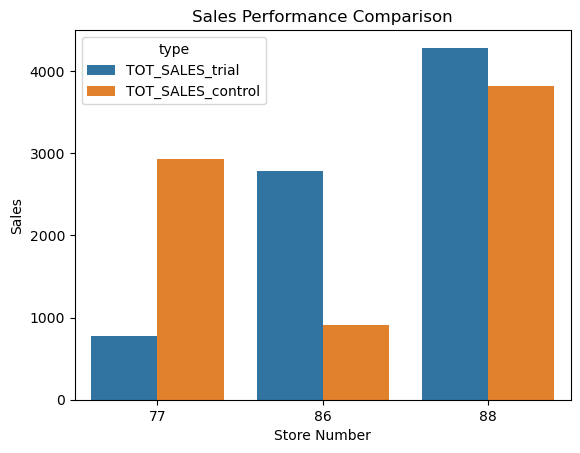

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data for visualization
performance_melted = performance_comparison.melt(
    id_vars='STORE_NBR_trial', 
    value_vars=['TOT_SALES_trial', 'TOT_SALES_control'], 
    var_name='type', 
    value_name='TOT_SALES'
)

# Ensure performance_melted is correctly populated
print(performance_melted)

# Visualize sales performance
sns.barplot(x='STORE_NBR_trial', y='TOT_SALES', hue='type', data=performance_melted)
plt.title('Sales Performance Comparison')
plt.xlabel('Store Number')
plt.ylabel('Sales')
plt.show()



- **Store Numbers (Trial):**
  - Store 77 (Trial)
  - Store 86 (Trial)
  - Store 88 (Trial)

- **Store Numbers (Control):**
  - Store 77 (Control)
  - Store 86 (Control)
  - Store 88 (Control)

- **Total Sales:**
  - Total sales for each trial store (TOT_SALES_trial)
  - Total sales for each control store (TOT_SALES_control)

Now, we can visualize the sales performance comparison between trial and control stores using a bar plot. This plot will display the total sales for each store, distinguishing between trial and control groups.

Let's interpret the output and visualize it:

 For  Store  77,  the trial sales were doller 777.0 and the control sales were doller 2928.0.
 For Store 86, the trial sales were doller 2788.2 and  the control sales were doller 905.0.
 For  Store  88,  the  trial  sales  were  doller 4286.8  and  the  control  sales  were doller 3817.6.
 
This visualization will provide a clear comparison between trial and control stores in terms of total sales during the trial period.